In [13]:
#--------------------------------------------------
# load the file containing all of the captions into a single long string
#--------------------------------------------------

caption_file = "Flicker8k/Flicker8k_text/Flickr8k.token.txt"
def load_captions (filename):
    with open(filename, "r") as fp:
    # Read all text in the file
    
        text = fp.read()
        return (text)

#--------------------------------------------------
# Each photo has a unique identifier, which is the file name of the image .jpg file
# Create a dictionary of photo identifiers (without the .jpg) to captions. Each photo identifier maps to
# a list of one or more textual descriptions.
#
# {"image_name_1" : ["caption 1", "caption 2", "caption 3"],
#  "image_name_2" : ["caption 4", "caption 5"]}
#--------------------------------------------------

def captions_dict (text):
    dict = {}

    # Make a List of each line in the file
    lines = text.split ('\n')
    for line in lines:

        # Split into the <image_data> and <caption>
        line_split = line.split ('\t')
        if (len(line_split) != 2):
            # Added this check because dataset contains some blank lines
            continue
        else:
            image_data, caption = line_split

        # Split into <image_file> and <caption_idx>
        image_file, caption_idx = image_data.split ('#')
        # Split the <image_file> into <image_name>.jpg
        image_name = image_file.split ('.')[0]

        # If this is the first caption for this image, create a new list for that
        # image and add the caption to it. Otherwise append the caption to the 
        # existing list
        if (int(caption_idx) == 0):
            dict [image_name] = [caption]
        else:
            dict [image_name].append (caption)

    return (dict)

doc = load_captions (caption_file)
image_dict = captions_dict (doc)

In [14]:
#--------------------------------------------------
# We have three separate files which contain the names for the subset of 
# images to be used for training, validation or testing respectively
#
# Given a file, we return a set of image names (without .jpg extension) in that file
#--------------------------------------------------
def subset_image_name (filename):
    data = []

    with open(filename, "r") as fp:
        # Read all text in the file
        text = fp.read()

        # Make a List of each line in the file
        lines = text.split ('\n')
        for line in lines:
            # skip empty lines
            if (len(line) < 1):
                continue

            # Each line is the <image_file>
            # Split the <image_file> into <image_name>.jpg
            image_name = line.split ('.')[0]

            # Add the <image_name> to the list
            data.append (image_name)

    return (set(data))  

training_image_name_file = "Flicker8k/Flicker8k_text/Flickr_8k.trainImages.txt"
training_image_names = subset_image_name (training_image_name_file)

In [15]:
import numpy as np
import tensorflow as tf

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    return img, image_path
    
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

from tqdm import tqdm

image_dir = "Flicker8k/Flicker8k_Dataset/"
training_image_paths = [image_dir + name + '.jpg' for name in training_image_names]

# Get unique images
encode_train = sorted(set(training_image_paths))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
    batch_features1 = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features1, (batch_features1.shape[0], -1, batch_features1.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:39<00:00,  9.42it/s]


In [16]:
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import re

#--------------------------------------------------
# Clean the captions data
#    Convert all words to lowercase.
#    Remove all punctuation.
#    Remove all words that are one character or less in length (e.g. ‘a’).
#    Remove all words with numbers in them.
#--------------------------------------------------

def captions_clean (image_dict):
    # <key> is the image_name, which can be ignored
    for key, captions in image_dict.items():

        # Loop through each caption for this image
        for i, caption in enumerate (captions):

            # Convert the caption to lowercase, and then remove all special characters from it
            caption_nopunct = re.sub(r"[^a-zA-Z0-9]+", ' ', caption.lower())

            # Split the caption into separate words, and collect all words which are more than 
            # one character and which contain only alphabets (ie. discard words with mixed alpha-numerics)
            clean_words = [word for word in caption_nopunct.split() if ((len(word) > 1) and (word.isalpha()))]

            # Join those words into a string
            caption_new = ' '.join(clean_words)

            # Replace the old caption in the captions list with this new cleaned caption
            captions[i] = caption_new
            

            
#--------------------------------------------------
# Add two tokens, 'startseq' and 'endseq' at the beginning and end respectively, 
# of every caption
#--------------------------------------------------

def add_token (captions):
    for i, caption in enumerate (captions):
        captions[i] = 'startseq ' + caption + ' endseq'
    return (captions)

#--------------------------------------------------
# Given a set of training, validation or testing image names, return a dictionary
# containing the corresponding subset from the full dictionary of images with captions
#
# This returned subset has the same structure as the full dictionary
# {"image_name_1" : ["caption 1", "caption 2", "caption 3"],
#  "image_name_2" : ["caption 4", "caption 5"]}
#--------------------------------------------------

def subset_data_dict (image_dict, image_names):
    dict = { image_name:add_token(captions) for image_name,captions in image_dict.items() if image_name in image_names}
    return (dict)

#--------------------------------------------------
# Flat list of all captions
#--------------------------------------------------

def all_captions (data_dict):
    return ([caption for key, captions in data_dict.items() for caption in captions])

#--------------------------------------------------
# Calculate the word-length of the caption with the most words
#--------------------------------------------------

def max_caption_length(captions):
    return max(len(caption.split()) for caption in captions)

#--------------------------------------------------
# Fit a Keras tokenizer given caption descriptions
# The tokenizer uses the captions to learn a mapping from words to numeric word indices
#
# Later, this tokenizer will be used to encode the captions as numbers
#--------------------------------------------------

def create_tokenizer(data_dict):
    captions = all_captions(data_dict)
    max_caption_words = max_caption_length(captions)
  
    # Initialise a Keras Tokenizer
    tokenizer = Tokenizer()

    # Fit it on the captions so that it prepares a vocabulary of all words
    tokenizer.fit_on_texts(captions)

    # Get the size of the vocabulary
    vocab_size = len(tokenizer.word_index) + 1

    return (tokenizer, vocab_size, max_caption_words)

#--------------------------------------------------
# Extend a list of text indices to a given fixed length
#--------------------------------------------------

def pad_text (text, max_length): 
    text = pad_sequences([text], maxlen=max_length, padding='post')[0]

    return (text)

captions_clean (image_dict)
training_dict = subset_data_dict (image_dict, training_image_names)

# Prepare tokenizer
tokenizer, vocab_size, max_caption_words = create_tokenizer(training_dict)

In [18]:
training_dict

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tri colored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow ends

In [19]:
import numpy as np

def data_prep(data_dict, tokenizer, max_length, vocab_size):
    X, y = list(), list()

    # For each image and list of captions
    for image_name, captions in data_dict.items():
        image_name = image_dir + image_name + '.jpg'

    # For each caption in the list of captions
    for caption in captions:

        # Convert the caption words into a list of word indices
        word_idxs = tokenizer.texts_to_sequences([caption])[0]

        # Pad the input text to the same fixed length
        pad_idxs = pad_text(word_idxs, max_length)

        X.append(image_name)
        y.append(pad_idxs)
        
    
    X = np.array(X)
    y = np.array(y)
    return X, y

train_X, train_y = data_prep(training_dict, tokenizer, max_caption_words, vocab_size)

In [20]:
type(train_X)

numpy.ndarray

In [21]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function
                      (map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [22]:
dataset

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

In [23]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [24]:
embedding_dim = 256
units = 512
vocab_size = vocab_size
num_steps = len(train_X) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

loss_plot = []
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

import time
start_epoch = 0
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.0343
Epoch 1 Loss inf
Time taken for 1 epoch 31.19 sec

Epoch 2 Batch 0 Loss 1.9145
Epoch 2 Loss inf
Time taken for 1 epoch 0.16 sec

Epoch 3 Batch 0 Loss 1.6746
Epoch 3 Loss inf
Time taken for 1 epoch 0.17 sec

Epoch 4 Batch 0 Loss 1.3035
Epoch 4 Loss inf
Time taken for 1 epoch 0.16 sec

Epoch 5 Batch 0 Loss 0.9474
Epoch 5 Loss inf
Time taken for 1 epoch 0.17 sec

Epoch 6 Batch 0 Loss 0.7879
Epoch 6 Loss inf
Time taken for 1 epoch 0.16 sec

Epoch 7 Batch 0 Loss 0.7579
Epoch 7 Loss inf
Time taken for 1 epoch 0.16 sec

Epoch 8 Batch 0 Loss 0.7655
Epoch 8 Loss inf
Time taken for 1 epoch 0.16 sec

Epoch 9 Batch 0 Loss 0.7764
Epoch 9 Loss inf
Time taken for 1 epoch 0.16 sec

Epoch 10 Batch 0 Loss 0.7728
Epoch 10 Loss inf
Time taken for 1 epoch 0.16 sec

Epoch 11 Batch 0 Loss 0.7479
Epoch 11 Loss inf
Time taken for 1 epoch 0.17 sec

Epoch 12 Batch 0 Loss 0.7234
Epoch 12 Loss inf
Time taken for 1 epoch 0.17 sec

Epoch 13 Batch 0 Loss 0.7401
Epoch 13 Loss inf
Time taken

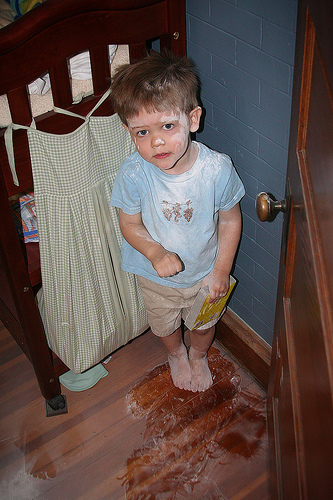

Real Caption: ['child and floor covered in white powder', 'little boy is in the corner covered in white powder that is all over him and the floor', 'little boy with mess all over his face and feet stands next to door', 'young boy is caught making mess of his room', 'young child covered with white powder']
Prediction Caption: writes decorated endseq


In [25]:
def evaluate(image, max_length):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['startseq']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == 'endseq':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot
  
def check_test(test_image_names, image_dict, image_dir, max_caption_words):
    # captions on the validation set
    rid = np.random.randint(0, len(test_image_names))
    image_name = test_image_names[rid]
    real_caption = image_dict[image_name]

    image_path = image_dir + image_name + '.jpg'
    result, attention_plot = evaluate(image_path, max_caption_words)

    from IPython.display import Image, display
    display(Image(image_path))
    print('Real Caption:', real_caption)
    print('Prediction Caption:', ' '.join(result))


test_image_name_file = "Flicker8k/Flicker8k_text/Flickr_8k.testImages.txt"
test_image_names = subset_image_name (test_image_name_file)
image_dir = "Flicker8k/Flicker8k_Dataset/"
check_test(list(test_image_names), image_dict, image_dir, max_caption_words)